In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import json 
import collections
import astropy

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [3]:
from astropy.io import fits

In [4]:
data = Table(fits.open("asu.fit")[1].data)

In [5]:
info = data["_RAJ2000", "_DEJ2000", "WiseID"]

In [6]:
info.to_pandas().to_csv("radecid.csv", index = False)

In [7]:
gaia_data = Table(fits.open("1634333877715O-result.fits")[1].data)

In [8]:
gaia_data_good = gaia_data[np.where((gaia_data["parallax"] > 0) & (np.isnan(gaia_data["bp_rp"]) == False) & (gaia_data["phot_g_mean_mag"] < 18.5))]

In [9]:
distance = 1/(gaia_data_good["parallax"]/1000)
absolute_M = gaia_data_good["phot_g_mean_mag"] - 5 * np.log10(distance)

Text(0.5, 1.0, 'HR Diagram of the stars in M67')

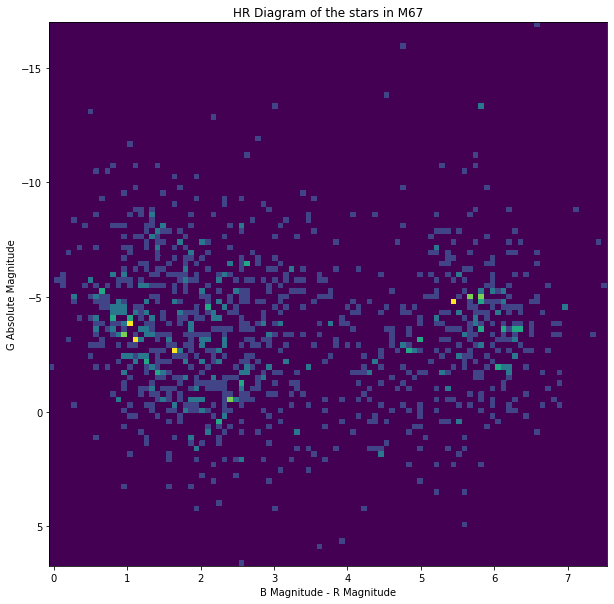

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
ax.hist2d(gaia_data_good["bp_rp"], absolute_M, bins = 100)
ax.invert_yaxis()
plt.ylabel("G Absolute Magnitude")
plt.xlabel("B Magnitude - R Magnitude")
plt.title("HR Diagram of the stars in M67")

In [34]:
best_options = gaia_data_good[np.where((absolute_M < -3))]

In [35]:
best_options.rename_column('wiseid', 'WiseID')

In [36]:
joined = astropy.table.join(data, best_options)

In [37]:
locations = joined["WiseID", "source_id", "ra", "dec"]

In [38]:
utcoffset = -7*u.hour

In [39]:
c = SkyCoord(ra = joined["ra"], dec = joined["dec"], frame="icrs", unit="deg")

In [40]:
palomar = astropy.coordinates.EarthLocation.of_site("palomar")

In [41]:
time = Time('2021-10-22 23:00:00') - utcoffset

In [42]:
c_altaz = c.transform_to(AltAz(obstime = time, location = palomar))

In [43]:
airmass = c_altaz.secz

In [44]:
airmass_np = np.array(airmass)

In [45]:
alt = np.array(c_altaz.alt)
az = np.array(c_altaz.az)

In [46]:
joined["airmass"] = airmass_np
joined["alt"] = alt
joined["az"] = az

In [47]:
moon = astropy.coordinates.get_moon(time = time, location = palomar)

In [48]:
moon_altaz = moon.transform_to(AltAz(obstime = time, location = palomar))

In [49]:
moon_altaz

<SkyCoord (AltAz: obstime=2021-10-23 06:00:00.000, location=(-2410346.78217658, -4758666.82504051, 3487942.97502457) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (92.95808116, 41.45915347, 4.00482372e+08)>

In [50]:
moon_sep = np.array(moon_altaz.separation(c_altaz))

In [51]:
joined["moon_sep"] = moon_sep

(array([38., 26., 13., 13., 15., 13., 14.,  5.,  2.,  2.]),
 array([1.02767273, 1.22420422, 1.4207357 , 1.61726719, 1.81379868,
        2.01033017, 2.20686165, 2.40339314, 2.59992463, 2.79645612,
        2.9929876 ]),
 <BarContainer object of 10 artists>)

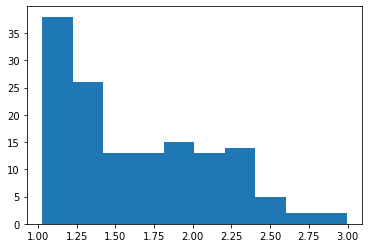

In [52]:
visible = joined[np.where((joined["airmass"] > 1) & (joined["airmass"] < 3) & (joined["moon_sep"] > 20))]
plt.hist(visible["airmass"])

In [53]:
visible.to_pandas().to_csv("visiblemore.csv")

In [54]:
np.unique(visible["SType"])

""
*
*iA
Ae*
Be*
C*
DN*
Em*
IR
LP*
Mi*


In [55]:
visible["ra", "dec"]

ra,dec
float64,float64
2.1755100290452916,63.009350314872854
2.24931042052108,52.35624696615152
4.704317800991182,58.62286894622674
4.794283260095182,52.03424331503062
6.218959048881913,-1.8931928853308255
7.338255698779419,64.81405828931211
11.332036813351568,58.50510966665257
11.617747391908509,58.90579488512996
12.093001394512248,74.29927798726271
